Loading data...
Engineering features...
Training XGBoost Regressor...

 XGBOOST METRICS (OUTLIERS REMOVED) 
Mean Absolute Error (MAE): 1.1880 rings
Root Mean Squared Error (RMSE): 1.5520 rings
R^2 Score: 0.5769
Tolerance Accuracy (+/- 1 Ring): 72.25%

Generating Evaluation Charts...
Charts saved successfully as 'xgboost_regression_graphs.png'!


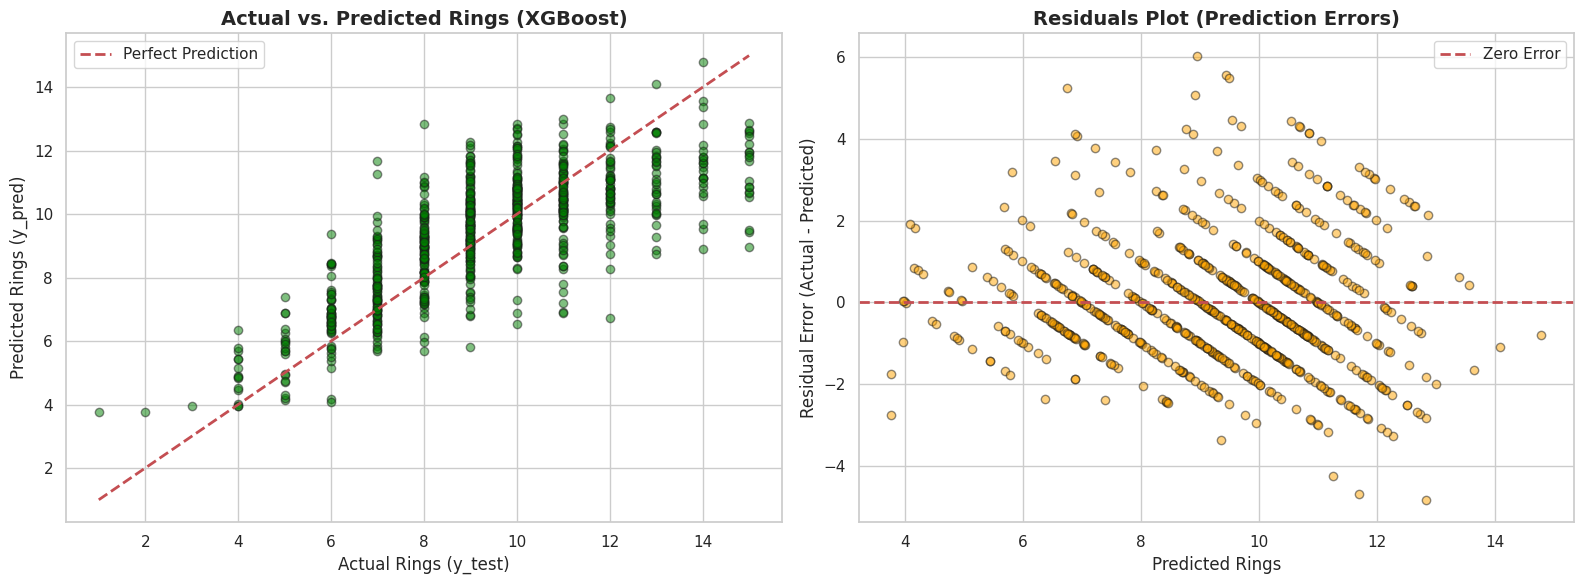

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# 1. Load Data
print("Loading data...")
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
                'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
df = pd.read_csv(url, names=column_names)

# 2. THE SECRET SAUCE: Remove Extreme Outliers
# We drop abalones with > 15 rings to bypass the biological plateau
df = df[(df['Rings'] <= 15) & (df['Whole_weight'] <= 2.5)]

# 3. Feature Engineering
print("Engineering features...")
df = pd.get_dummies(df, columns=['Sex'], prefix='Sex')
df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
df['Density'] = df['Whole_weight'] / (df['Volume'] + 1e-5)

X = df.drop('Rings', axis=1)
y = df['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train the XGBoost Regressor
print("Training XGBoost Regressor...")
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=150,      # Number of sequential trees
    learning_rate=0.05,    # Slow learning rate to prevent overfitting
    max_depth=5,           # Limits tree depth
    subsample=0.8,         # Uses 80% of data per tree to generalize better
    random_state=42
)

xg_reg.fit(X_train, y_train)

# 5. Evaluate the Model
y_pred = xg_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Calculate Tolerance Accuracy (+/- 1 Ring)
y_pred_rounded = np.round(y_pred)
tolerance_acc = np.mean(np.abs(y_pred_rounded - y_test) <= 1) * 100

print("\n" + "="*50)
print(" XGBOOST METRICS (OUTLIERS REMOVED) ")
print("="*50)
print(f"Mean Absolute Error (MAE): {mae:.4f} rings")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} rings")
print(f"R^2 Score: {r2:.4f}")
print(f"Tolerance Accuracy (+/- 1 Ring): {tolerance_acc:.2f}%")
print("="*50)

# ==========================================
# 6. GENERATE EVALUATION GRAPHS
# ==========================================
print("\nGenerating Evaluation Charts...")

# Set up the figure with 2 subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_theme(style="whitegrid")

# --- CHART 1: Actual vs Predicted ---
axes[0].scatter(y_test, y_pred, alpha=0.5, color='green', edgecolor='k')
# Draw the perfect 45-degree line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

axes[0].set_title('Actual vs. Predicted Rings (XGBoost)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Rings (y_test)', fontsize=12)
axes[0].set_ylabel('Predicted Rings (y_pred)', fontsize=12)
axes[0].legend()

# --- CHART 2: Residual Plot (Errors) ---
# Residuals = Actual - Predicted
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.5, color='orange', edgecolor='k')
# Draw a horizontal line at 0 (zero error)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')

axes[1].set_title('Residuals Plot (Prediction Errors)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Rings', fontsize=12)
axes[1].set_ylabel('Residual Error (Actual - Predicted)', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.savefig('xgboost_regression_graphs.png')
print("Charts saved successfully as 'xgboost_regression_graphs.png'!")